In [84]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
import copy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [85]:
def f_loc(T, D, X):
  loc = (0.3*D + 4*D*X[:,1] + X[:, 0] - 3*X[:,3]) * T - 3*X[:, 1]**2*np.exp(T)
  return loc

def f_scale(T, D, X):
  scale = np.sqrt(1*D + 2*D*X[:,1] + 1)
  return scale

def dgp(n=200, p=5):
    X = np.random.uniform(0,0.5,size=[n,p])
    D = ((X[:,1] - 3*X[:, 0] + np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    T_vec = np.array([1, 2, 3])
    Y0 = np.full(shape=(n,len(T_vec)), fill_value=np.nan)
    Y1 = np.full(shape=(n,len(T_vec)), fill_value=np.nan)
    for T_idx, T in enumerate(T_vec):
        Y0[:, T_idx] = f_loc(T, 0, X) + f_scale(T, 0, X)*epsilon
        Y1[:, T_idx] = f_loc(T, 1, X) + f_scale(T, 1, X)*epsilon

    Y = copy.deepcopy(Y0)
    Y[D == 1, len(T_vec)-1] = Y1[D == 1, len(T_vec)-1]
    return Y, X, D, epsilon, Y1, Y0

In [86]:
p = 5
n_true = int(10e+6)

Y_true, _, D_true, _, Y1, Y0 = dgp(n=n_true, p = p)

<AxesSubplot: xlabel='Time', ylabel='Outcome'>

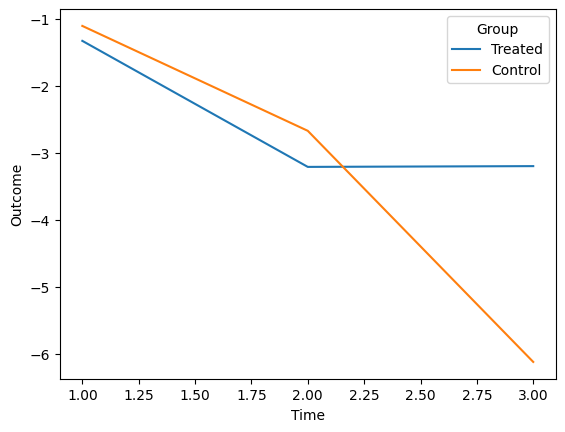

In [87]:
import seaborn as sns

data_dic ={"Outcome":  np.concatenate((Y_true[D_true == 1,:].mean(axis=0), Y_true[D_true == 0,:].mean(axis=0))),
            "Time" : np.array([1, 2, 3 , 1, 2, 3]),
            "Group": ["Treated", "Treated", "Treated", "Control", "Control", "Control"]}
df = pd.DataFrame(data_dic)

sns.lineplot(df, x="Time", y="Outcome", hue="Group")

In [88]:
ATT = np.mean(Y1[D_true == 1, 2] - Y0[D_true == 1, 2])
ATT

4.151738510253498

In [89]:
n = 1000
np.random.seed(42)
Y, X, D, _, _, _ = dgp(n=n,p=p)
Y_diff = Y[:, 2] - Y[:, 1]
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y_diff, D)

In [90]:
ml_g = RandomForestRegressor(n_estimators=50)
ml_m = RandomForestClassifier(n_estimators=50)

dml_DiD = dml.DoubleMLDID(obj_dml_data, ml_g, ml_m,n_folds=5)

dml_DiD.fit()

print(dml_DiD.coef)
dml_DiD.confint(level=0.95)

[3.94309439]


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


,2.5 %,97.5 %
d,3.732052,4.154137
